In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
df = pd.read_csv('data.csv.zip')

In [4]:
countries = ["BRA", "IND", "RUS", "CHN", "ZAF", "USA", "DEU", "JPN", "GBR", "FRA", "ITA", "CAN", "MEX", "AUS", "KOR", "IND", "IDN", "TUR", "SAU", "ARG"]

data = df[df["CountryCode"].isin(countries) & df["Year"].isin(range(2000, 2019))]
data.head()


,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
3193649,Argentina,ARG,Access to electricity (% of population),EG.ELC.ACCS.ZS,2000,92.347130
3193650,Argentina,ARG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,2000,88.586720
3193651,Argentina,ARG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,2000,92.759158
3193652,Argentina,ARG,Access to non-solid fuel (% of population),EG.NSF.ACCS.ZS,2000,93.116722
3193653,Argentina,ARG,Adjusted net national income (annual % growth),NY.ADJ.NNTY.KD.ZG,2000,-2.506788


In [5]:
from typing import List

def transform_data(data: pd.DataFrame, indicators: List[str], names: List[str]) -> pd.DataFrame:
    indicators_data = [data[data["IndicatorCode"] == i] for i in indicators]
    
    transformed_data = indicators_data[0]
    transformed_data = transformed_data.rename(columns={"Value": names[0]})
    transformed_data = transformed_data.drop(columns=["IndicatorName", "IndicatorCode"])
    for i in range(1, len(indicators_data)):
        transformed_data = pd.merge(transformed_data, indicators_data[i], on=["CountryName", "CountryCode", "Year"])
        transformed_data = transformed_data.rename(columns={"Value": names[i]})
        transformed_data = transformed_data.drop(columns=["IndicatorName", "IndicatorCode"])

    return transformed_data


In [52]:
transformed_data = transform_data(data, ["NY.GDP.MKTP.KD.ZG", "NY.GDP.PCAP.CD"], ["Growth", "GdpPerCapita"])
transformed_data.head()

,CountryName,CountryCode,Year,Growth,GdpPerCapita
0,Argentina,ARG,2000,-0.788999,7669.273709
1,Australia,AUS,2000,3.868658,21665.115454
2,Brazil,BRA,2000,4.383025,3738.719412
3,Canada,CAN,2000,5.123122,24031.951202
4,China,CHN,2000,8.429282,954.552292


In [21]:
sns.set_style("dark")


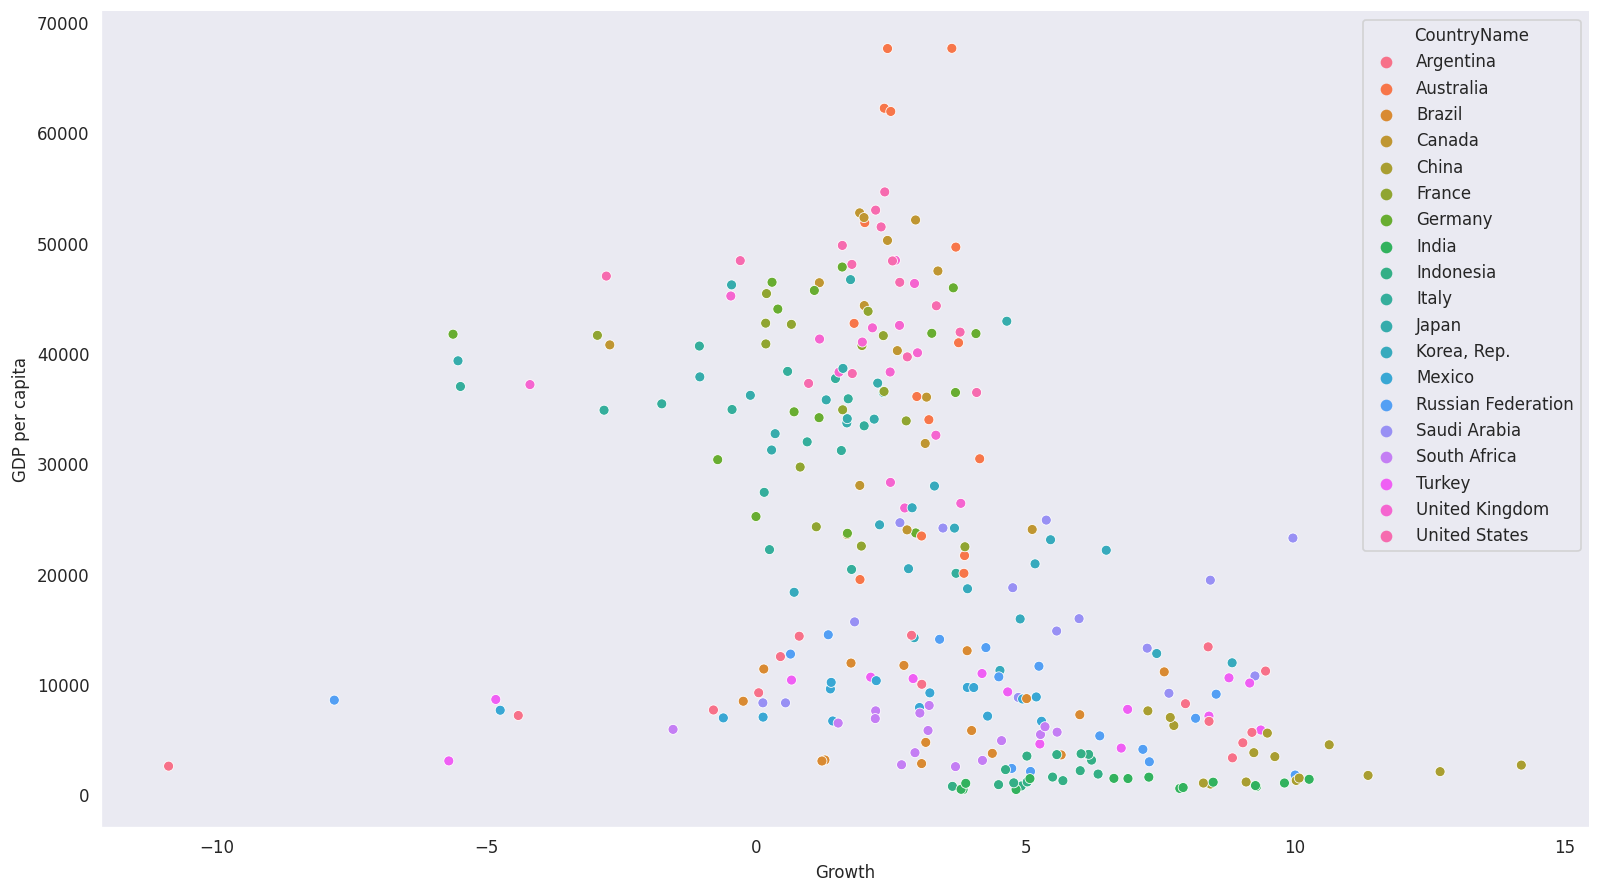

In [53]:
# seaborn plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=120)
sns.scatterplot(
    x="Growth",
    y="GdpPerCapita",
    hue="CountryName",
    data=transformed_data,
    ax=ax,
)
sns.despine()
ax.set_xlabel("Growth")
ax.set_ylabel("GDP per capita")
plt.show()


In [24]:
def J(u: np.ndarray, v: np.ndarray, data: np.ndarray, m: int = 2) -> float:
    return np.sum(
        u**m
        * np.linalg.norm(data[:, np.newaxis, :] - v[np.newaxis, :, :], axis=2) ** 2
    )


def fuzzy_c_means_generator(
    data: np.ndarray, n_clusters: int, m: int = 2, tol: float = 1e-4
) -> np.ndarray:
    u = np.random.rand(data.shape[0], n_clusters)
    u /= u.sum(axis=1, keepdims=True)

    v = np.random.rand(n_clusters, data.shape[1]) * data.max()

    J1 = J(u, v, data, m)
    J2 = np.inf

    while np.abs(J1 - J2) > tol:
        for i in range(data.shape[0]):
            for j in range(n_clusters):
                d1 = np.linalg.norm(data[i] - v[j])
                d2s = np.linalg.norm(data[i] - v, axis=1)
                u[i, j] = 1 / np.sum(np.power(d1 / d2s, 2 / (m - 1)))

        for j in range(n_clusters):
            s1 = np.sum(u[:, j, np.newaxis] ** m * data, axis=0)
            s2 = np.sum(u[:, j] ** m)
            v[j] = s1 / s2

        J2 = J1
        J1 = J(u, v, data, m)

        yield u.copy(), v.copy()

def fuzzy_c_means(data: np.ndarray, n_clusters: int, m: int = 2, tol: float = 1e-4) -> np.ndarray:
    return list(fuzzy_c_means_generator(data, n_clusters, m, tol))[-1]



array([[6.06510683e+00, 2.19322431e+03],
       [1.04294381e+00, 3.78967664e+04],
       [1.80072872e+00, 4.91264918e+04],
       [4.11188455e+00, 1.35606662e+04],
       [3.14283416e+00, 2.44016273e+04],
       [3.46182788e+00, 7.88906123e+03]])

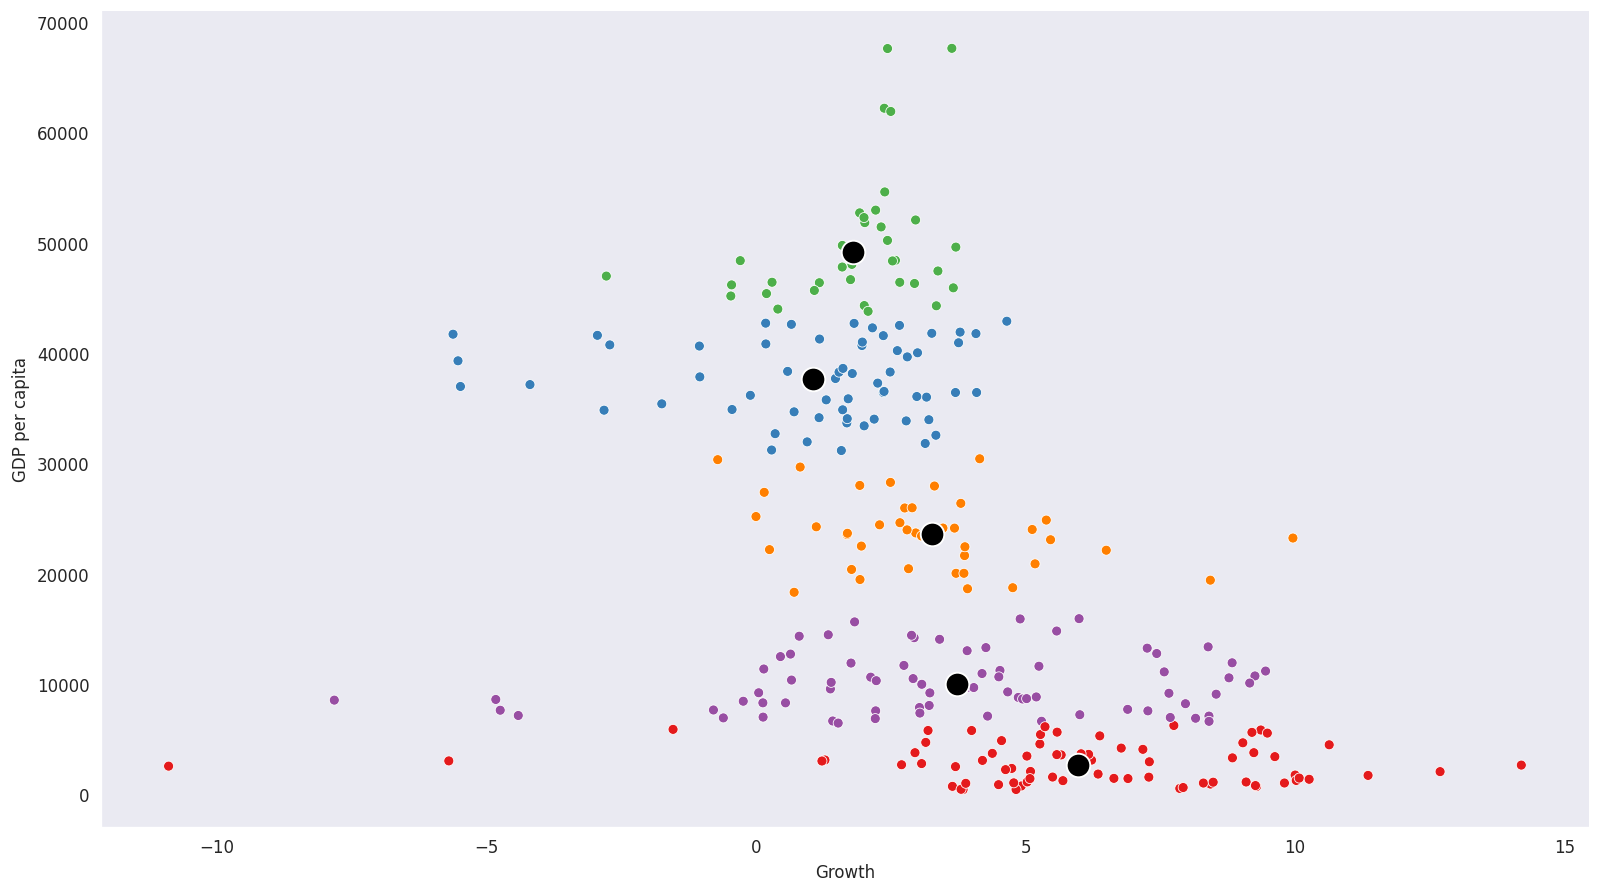

In [49]:
u, v = fuzzy_c_means(transformed_data[["Growth", "GdpPerCapita"]].values, n_clusters=5, tol=1e-4)
v

centroids = pd.DataFrame(v, columns=["Growth", "GdpPerCapita"])
centroids

plot_data = transformed_data.copy()
plot_data["Cluster"] = np.argmax(u, axis=1)

fig, ax = plt.subplots(figsize=(16, 9), dpi=120)
sns.scatterplot(
    x="Growth",
    y="GdpPerCapita",
    hue="Cluster",
    data=plot_data,
    palette="Set1",
    ax=ax,
)
sns.scatterplot(
    x="Growth",
    y="GdpPerCapita",
    data=centroids,
    ax=ax,
    color="black",
    s=200,
)
sns.despine()
ax.set_xlabel("Growth")
ax.set_ylabel("GDP per capita")
ax.legend().remove()
plt.show()


71


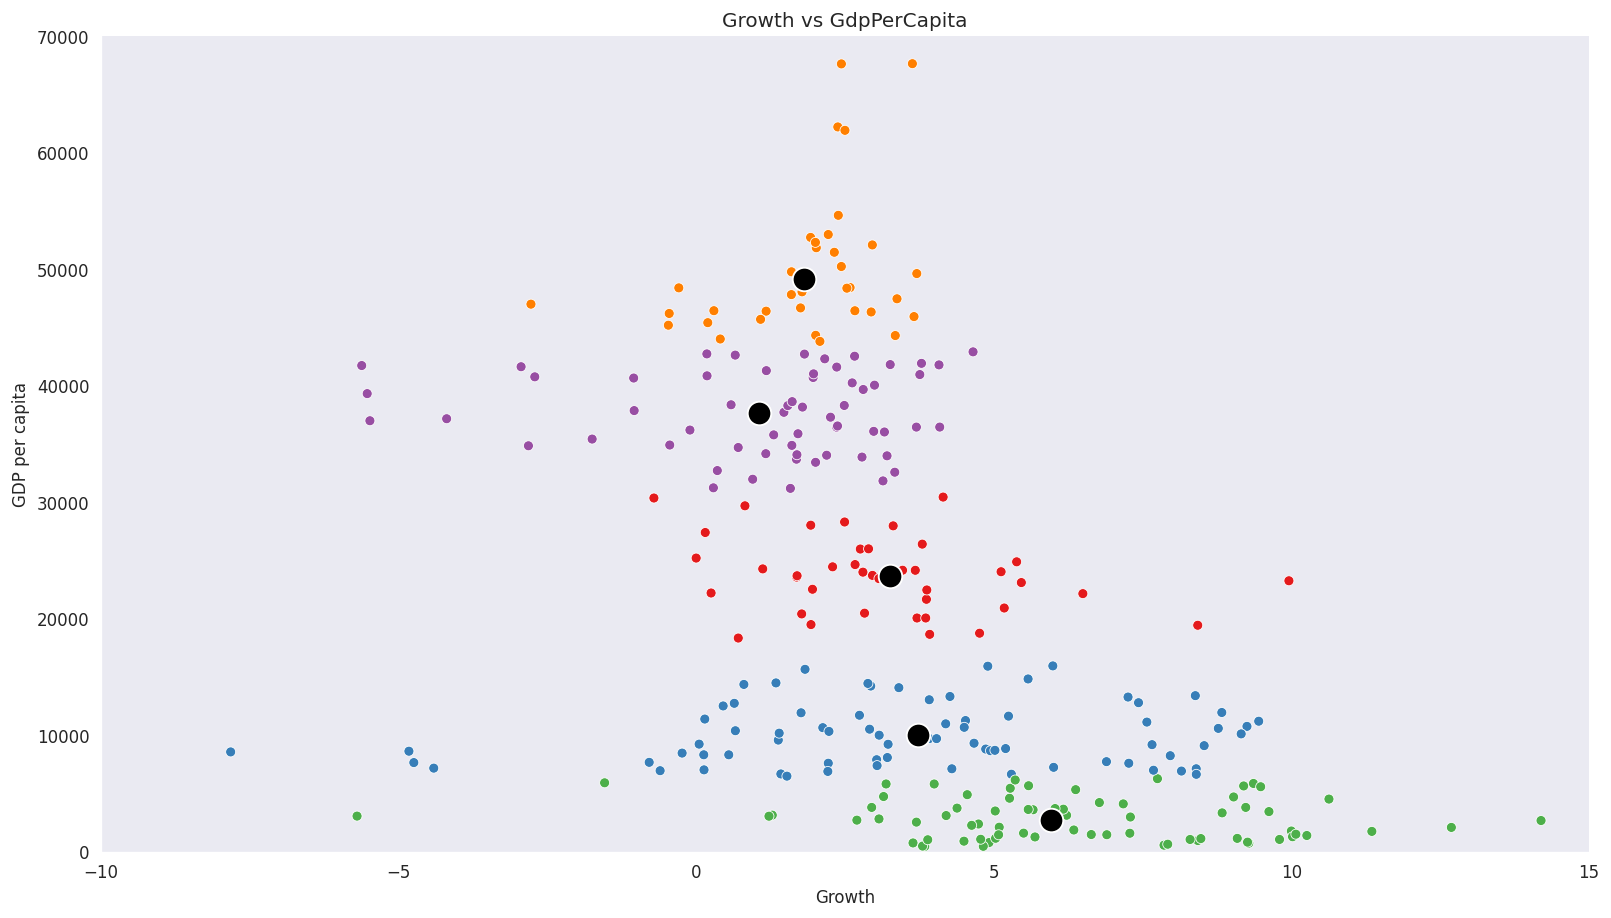

In [54]:

c_means = list(fuzzy_c_means_generator(transformed_data[["Growth", "GdpPerCapita"]].values, n_clusters=5, tol=1e-2))
print(len(c_means))

fig, ax = plt.subplots(figsize=(16, 9), dpi=120)

def animate(i):
    u, v = c_means[i]
    centroids = pd.DataFrame(v, columns=["Growth", "GdpPerCapita"])
    plot_data = transformed_data.copy()
    plot_data["Cluster"] = np.argmax(u, axis=1)
    ax.clear()
    sns.scatterplot(
        x="Growth",
        y="GdpPerCapita",
        hue="Cluster",
        data=plot_data,
        palette="Set1",
        ax=ax,
    )
    sns.scatterplot(
        x="Growth",
        y="GdpPerCapita",
        data=centroids,
        color="black",
        s=200,
        ax=ax,
    )
    sns.despine()
    ax.set_title("Growth vs GdpPerCapita")
    ax.set_xlabel("Growth")
    ax.set_ylabel("GDP per capita")
    ax.set_xlim(-10, 15)
    ax.set_ylim(0, 70000)
    ax.legend().remove()
 
anim = FuncAnimation(fig, animate, frames=len(c_means), interval=100)
anim.save("fuzzy_c_means.mp4")
plt.show()

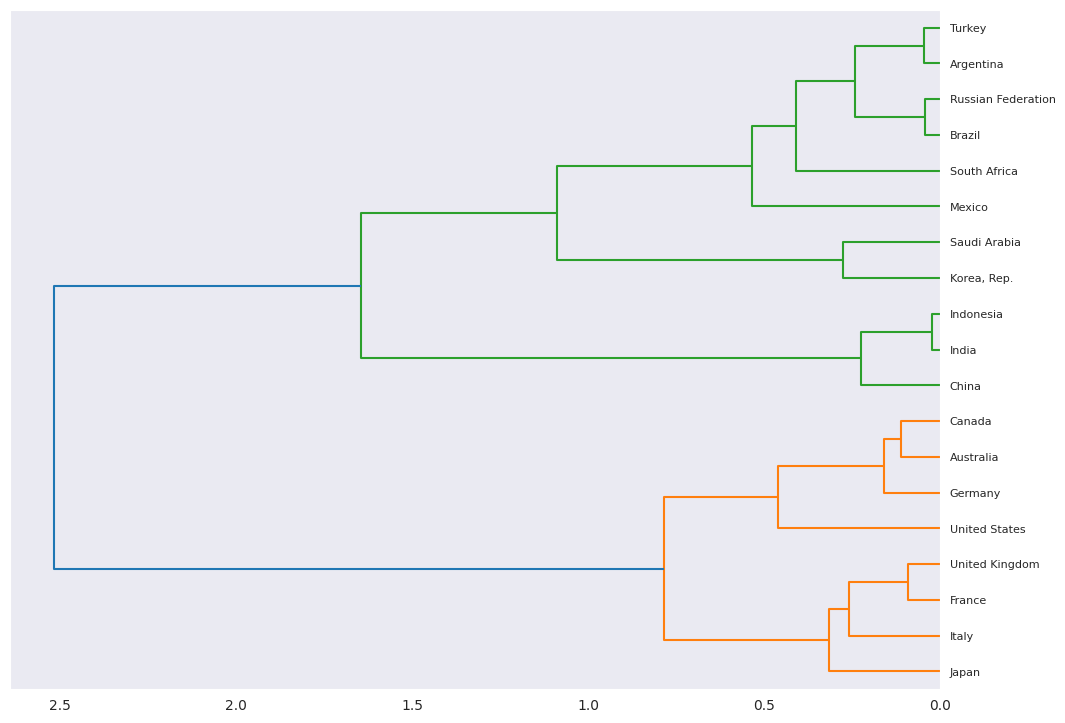

In [70]:
transformed_data = transform_data(data, ["NY.GDP.MKTP.KD.ZG", "NY.GDP.PCAP.CD"], ["Growth", "GdpPerCapita"])
u, v = fuzzy_c_means(transformed_data[["Growth", "GdpPerCapita"]].values, n_clusters=5, tol=1e-3)

dendrogram_data = pd.DataFrame(u, columns=["Cluster" + str(i) for i in range(5)])
dendrogram_data["CountryName"] = plot_data["CountryName"].values
dendrogram_data = dendrogram_data.groupby("CountryName").mean()

Z = linkage(dendrogram_data, "ward")

plt.figure(figsize=(12, 9), dpi=100)

dendrogram(
    Z,
    labels=dendrogram_data.index,
    leaf_rotation=0,
    leaf_font_size=8,
    orientation="left",
)

plt.show()


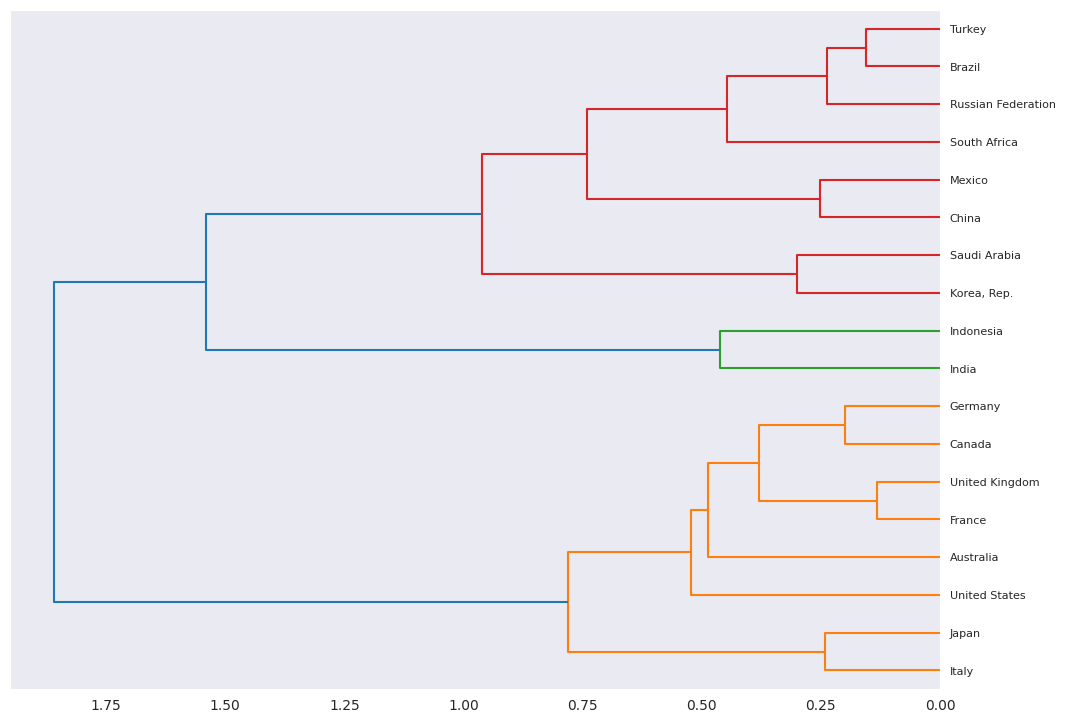

In [72]:
# Economic indicators: GDP Per Capita, Growth, Inflation, Unemployment, Population Growth
indicators = [
    "NY.GDP.PCAP.CD",
    "NY.GDP.MKTP.KD.ZG",
    "FP.CPI.TOTL.ZG",
    "SL.UEM.TOTL.ZS",
    "SP.POP.GROW",
]

transformed_data = transform_data(data, indicators, indicators)

C = 10
u, v = fuzzy_c_means(transformed_data[indicators].values, n_clusters=C, tol=1e-3)

dendrogram_data = pd.DataFrame(u, columns=["Cluster" + str(i) for i in range(C)])
dendrogram_data["CountryName"] = transformed_data["CountryName"].values
dendrogram_data = dendrogram_data.groupby("CountryName").mean()

Z = linkage(dendrogram_data, "ward")

plt.figure(figsize=(12, 9), dpi=100)

dendrogram(
    Z,
    labels=dendrogram_data.index,
    leaf_rotation=0,
    leaf_font_size=8,
    orientation="left",
)

plt.show()

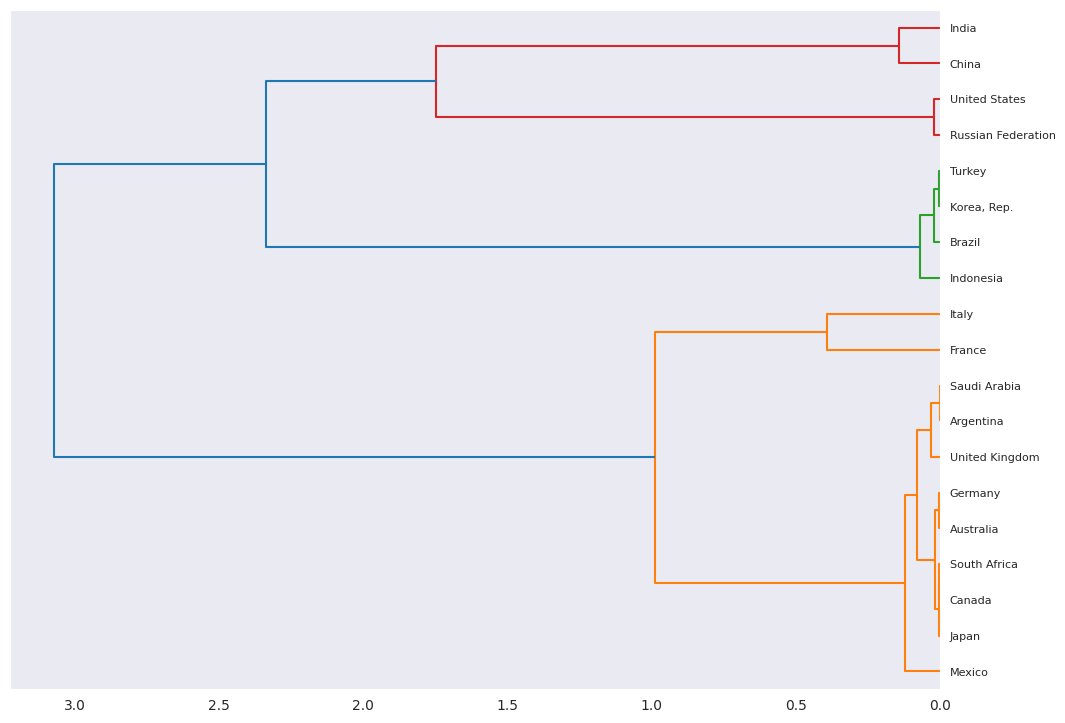

In [76]:
# Military indicators: Military Expenditure, Military Personnel, Military Personnel % of Population
indicators = [
    "MS.MIL.XPND.GD.ZS",
    "MS.MIL.TOTL.TF.ZS",
    "MS.MIL.TOTL.P1",
]

transformed_data = transform_data(data, indicators, indicators)

C = 4
u, v = fuzzy_c_means(transformed_data[indicators].values, n_clusters=C, tol=1e-3)

dendrogram_data = pd.DataFrame(u, columns=["Cluster" + str(i) for i in range(C)])
dendrogram_data["CountryName"] = transformed_data["CountryName"].values
dendrogram_data = dendrogram_data.groupby("CountryName").mean()
dendrogram_data.head()

Z = linkage(dendrogram_data, "ward")

plt.figure(figsize=(12, 9), dpi=100)

dendrogram(
    Z,
    labels=dendrogram_data.index,
    leaf_rotation=0,
    leaf_font_size=8,
    orientation="left",
)

plt.show()


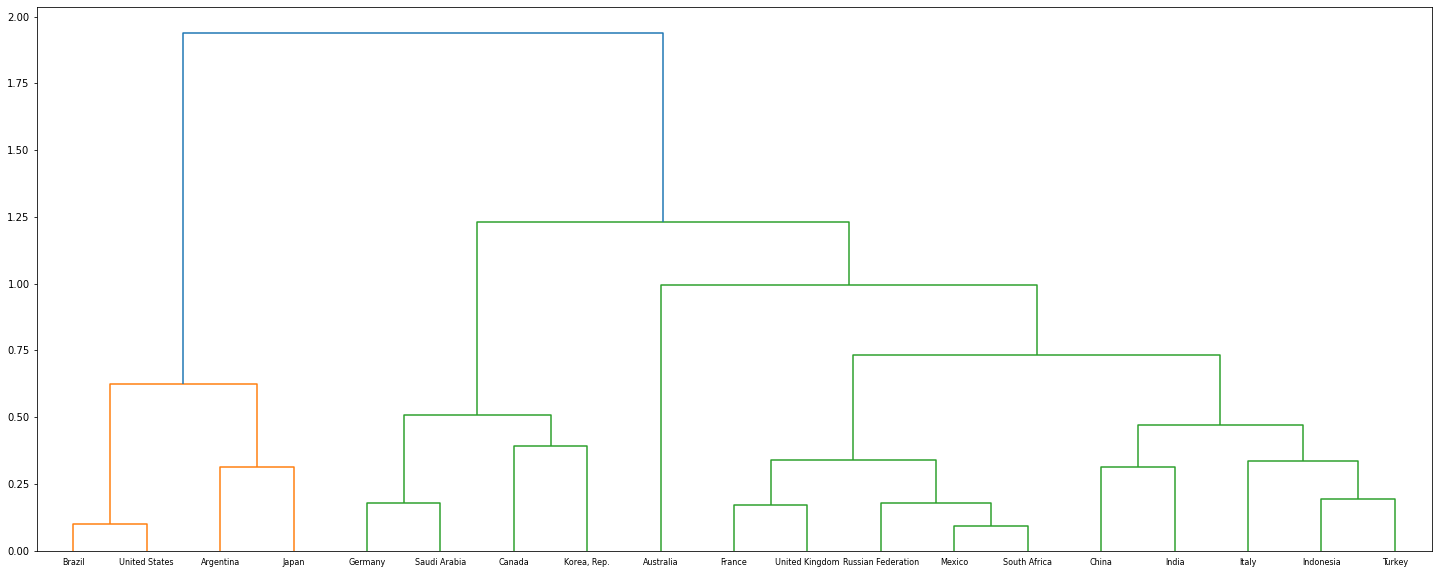

In [109]:
# Trade indicators: Exports, Imports, Trade Balance
indicators = [
    "NE.EXP.GNFS.ZS",
    "NE.IMP.GNFS.ZS",
    "NE.TRD.GNFS.ZS",
    # "NE.TRD.GNFS.KD.ZG",
]

transformed_data = transform_data(data, indicators, indicators)
# transformed_data.head()

C = 9
u, v = fuzzy_c_means(transformed_data[indicators].values, n_clusters=C, tol=1e-4)

dendrogram_data = pd.DataFrame(u, columns=["Cluster" + str(i) for i in range(C)])
dendrogram_data["CountryName"] = transformed_data["CountryName"].values
dendrogram_data = dendrogram_data.groupby("CountryName").mean()
dendrogram_data.head()

Z = linkage(dendrogram_data, "ward")

plt.figure(figsize=(25, 10))

dendrogram(
    Z,
    labels=dendrogram_data.index,
    leaf_rotation=0,
    leaf_font_size=8,
)

plt.show()